# 24B2120

## E11 - SPARK

---

This exercise **should be completed using the Azure VM** that you have created
  - Transfer this Notebook (***E11.ipynb***) to the VM
  - Create the solution using the VM
  - After solving the problem transfer the Notebook back to your local computer
  - Upload it to the E11 submission point
  - Do not forget to answer the questions asked in **https://forms.gle/86FH1Ng8Ywdcf16TA** (use your iitb.ac.in credentials)

**Submissions due by: November 26, 23:55 hrs** (strictly no extensions will be given)

Post your queries, if any, to the Moodle forum: [**Queries and Discussions**](https://moodle.iitb.ac.in/mod/forum/view.php?id=75889)

---

### Part-1
#### This section illustrates the use of SPARK Dataframe functions to process nsedata.csv
- Review **Part-1** to understand the code by referring to SPARK documentation.
- Add your comment to each cell, to explain its purpose
- Add code / create additional cells for debugging purpose, and comment them too

### Part-2 **[10 marks]**

  - This part carries 10 marks
    - 5 marks for the correctness and quality of ***properly commented*** code
    - 5 marks for overall correctness of the results
<br><br>
- Using SPARK functions, solve the problem stated in **Part-2**
  - (***DO NOT USE the createTempView function in your solution!***)
  - (***DO NOT USE PANDAS Dataframe in your solution***)

---

### Submission Guidelines
- **Part-1 and Part-2**
  - Upload this Notebook, with your solutio, to the E11 submission point.
    - **BEFORE UPLOADING, ENSURE THAT YOU REMOVE / TRIM LENGTHY DEBUG OUTPUTS**.
    - Short debug outputs of up to 5 lines are acceptable.
- **Part-2 [10 marks]**
  - Answer the questions in the Form: **https://forms.gle/86FH1Ng8Ywdcf16TA**

---


## <b>Part 1</b>

In [1]:
# Initialize the findspark module so that PySpark can be imported and used
# This allows the notebook to correctly locate and load the Spark installation
import findspark
findspark.init()

In [2]:
# Import the main PySpark package and required modules
import pyspark

# Import data type classes used to define a structured schema for reading the CSV file
from pyspark.sql.types import *

# Import PySpark SQL functions (aliased as F) used for column operations,
# filtering, aggregation, transformations, and date/number manipulation
from pyspark.sql import functions as F


In [3]:
# Create the SparkContext, which is the entry point for using Spark's core functionalities.
# The 'appName' sets the name of the Spark application visible in logs/UI.
sc = pyspark.SparkContext(appName="E9-2")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 16:31:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Create the SparkSession using the existing SparkContext.
# SparkSession is the main entry point for working with DataFrames and SQL operations in PySpark.
ss = pyspark.sql.SparkSession(sc)

In [5]:
# Create a reference to the DataFrame reader associated with the SparkSession.
# This 'dfr' object will be used later to read data files (e.g., CSV) into Spark DataFrames.
dfr = ss.read

In [6]:
# Define a structured schema for reading the NSE dataset.
# This ensures each column is assigned the correct data type when loading the CSV file.

schemaStruct = StructType()

# Add each column to the schema with its corresponding data type.
# The third argument 'True' indicates that the column can contain null values.
schemaStruct.add("SYMBOL", StringType(), True)       # Stock symbol
schemaStruct.add("SERIES", StringType(), True)       # Series type (e.g., EQ)
schemaStruct.add("OPEN", DoubleType(), True)         # Opening price
schemaStruct.add("HIGH", DoubleType(), True)         # Highest price of the day
schemaStruct.add("LOW", DoubleType(), True)          # Lowest price of the day
schemaStruct.add("CLOSE", DoubleType(), True)        # Closing price
schemaStruct.add("LAST", DoubleType(), True)         # Last traded price
schemaStruct.add("PREVCLOSE", DoubleType(), True)    # Previous day's closing price
schemaStruct.add("TOTTRDQTY", LongType(), True)      # Total traded quantity
schemaStruct.add("TOTTRDVAL", DoubleType(), True)    # Total traded value
schemaStruct.add("TIMESTAMP", StringType(), True)    # Date in string format
schemaStruct.add("ADDNL", StringType(), True)        # Additional field (unused)


StructType([StructField('SYMBOL', StringType(), True), StructField('SERIES', StringType(), True), StructField('OPEN', DoubleType(), True), StructField('HIGH', DoubleType(), True), StructField('LOW', DoubleType(), True), StructField('CLOSE', DoubleType(), True), StructField('LAST', DoubleType(), True), StructField('PREVCLOSE', DoubleType(), True), StructField('TOTTRDQTY', LongType(), True), StructField('TOTTRDVAL', DoubleType(), True), StructField('TIMESTAMP', StringType(), True), StructField('ADDNL', StringType(), True)])

In [7]:
# Read the NSE dataset CSV file into a Spark DataFrame using the predefined schema.
# 'header=True' tells Spark that the first row of the CSV contains column names.
df = dfr.csv("/home/hduser/spark/nsedata.csv", schema=schemaStruct, header=True)

#### <b>Basics : Using SPARK for analysis</b>

In [8]:
# Function to create a subset DataFrame for a given company (symbol).
# It filters rows for the specified company and renames the OHLC columns
# so that each company has uniquely identifiable column names when joined later.

def create_subset_from_df(company_code):
    tcode = company_code.lower()   # Convert company code to lowercase for naming consistency

    # Select the OHLC columns and timestamp, renaming them with the company code suffix.
    df_subset = df.select(
                    F.col("OPEN").alias("OPEN_" + tcode),
                    F.col("HIGH").alias("HIGH_" + tcode),
                    F.col("LOW").alias("LOW_" + tcode),
                    F.col("CLOSE").alias("CLOSE_" + tcode),
                    F.col("TIMESTAMP")
                ).where(F.col("SYMBOL") == company_code)   # Filter rows belonging to the selected company

    return df_subset   # Return the subset DataFrame


In [9]:
# Why do we need to use the alias function, above? What happens if we do not alias / rename the columns?
# -----------------------------
# When creating a subset for each company, all subsets contain the same column names:
# OPEN, HIGH, LOW, CLOSE, TIMESTAMP.
#
# Later, when multiple company DataFrames are joined together, Spark will face
# column name conflicts because the columns are identical across companies.
#
# If we do NOT rename (alias) the columns:
#   - Spark may throw an "ambiguous column" error during joins, OR
#   - Spark may overwrite columns or pick one arbitrarily, leading to incorrect results.
#
# By using alias(), we give each column a unique name such as:
#   OPEN_reliance, HIGH_reliance, CLOSE_tcs, LOW_infosys, etc.
#
# This ensures:
#   ✔ No column name conflicts during joins
#   ✔ Each company’s data remains clearly separated
#   ✔ Results are correct and unambiguous

In [10]:
# Create a subset DataFrame for the company INFY using the helper function defined earlier.
# This subset contains only INFY's OHLC values with uniquely renamed columns.
df_infy = create_subset_from_df("INFY")

# Display the first 5 rows of the INFY subset to verify that filtering and renaming worked correctly.
df_infy.show(5)

# Generate summary statistics (count, mean, stddev, min, max) for the INFY columns.
# This helps check data quality and understand the distribution of values.
df_infy.describe().show()


+---------+---------+--------+----------+-----------+
|OPEN_infy|HIGH_infy|LOW_infy|CLOSE_infy|  TIMESTAMP|
+---------+---------+--------+----------+-----------+
|  2910.75|  2953.55| 2910.75|    2944.2|01-APR-2013|
|  3283.05|   3325.0|  3275.0|   3313.95|01-APR-2014|
|   2198.9|   2199.5|  2157.7|   2173.95|01-APR-2015|
|   2780.1|   2823.8|  2780.1|    2815.1|01-AUG-2011|
|   2215.0|   2230.4| 2200.75|   2218.55|01-AUG-2012|
+---------+---------+--------+----------+-----------+
only showing top 5 rows



25/11/26 16:32:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+-----------+
|summary|         OPEN_infy|        HIGH_infy|          LOW_infy|        CLOSE_infy|  TIMESTAMP|
+-------+------------------+-----------------+------------------+------------------+-----------+
|  count|              1023|             1023|              1023|              1023|       1023|
|   mean|2707.2617302052795|2735.799413489735|2679.3007331378312|2708.2897849462406|       NULL|
| stddev| 641.7956780031782|647.6486140678146| 639.1258920145511| 643.8471963450963|       NULL|
|    min|             941.0|            952.1|            932.65|             937.5|01-APR-2013|
|    max|            4387.0|           4402.2|            4343.4|            4365.9|31-OCT-2014|
+-------+------------------+-----------------+------------------+------------------+-----------+



In [11]:
# Create a subset DataFrame for the company TCS using the same helper function.
# This extracts only TCS rows and renames the OHLC columns uniquely for TCS.
df_tcs = create_subset_from_df("TCS")

# Display the first 5 rows to confirm that the filtering and column renaming worked correctly.
df_tcs.show(5)

# Show summary statistics (count, mean, stddev, min, max) for the TCS subset.
# This helps understand basic data characteristics and check for anomalies.
df_tcs.describe().show()


+--------+--------+-------+---------+-----------+
|OPEN_tcs|HIGH_tcs|LOW_tcs|CLOSE_tcs|  TIMESTAMP|
+--------+--------+-------+---------+-----------+
|  1185.0| 1198.75|1172.55|  1180.15|01-APR-2011|
|  1565.0|  1573.7|1551.25|  1556.85|01-APR-2013|
|  2145.0|  2185.0| 2144.9|   2176.7|01-APR-2014|
|  2558.0|  2563.6|2522.25|  2542.65|01-APR-2015|
|  1142.4|  1149.9| 1125.1|  1135.25|01-AUG-2011|
+--------+--------+-------+---------+-----------+
only showing top 5 rows



+-------+------------------+------------------+------------------+-----------------+-----------+
|summary|          OPEN_tcs|          HIGH_tcs|           LOW_tcs|        CLOSE_tcs|  TIMESTAMP|
+-------+------------------+------------------+------------------+-----------------+-----------+
|  count|              1240|              1240|              1240|             1240|       1240|
|   mean|1678.2334677419353|1697.3971370967743|1658.5663306451613|1677.914798387098|       NULL|
| stddev| 598.9262836758081| 603.7783546396355| 592.8736960983055|597.8815093696456|       NULL|
|    min|             838.0|             847.7|             830.2|            837.3|01-APR-2011|
|    max|            2788.0|            2839.7|            2737.0|           2776.0|31-OCT-2014|
+-------+------------------+------------------+------------------+-----------------+-----------+



In [12]:
# Join the TCS and INFY subset DataFrames on the common column 'TIMESTAMP'.
# Since both subsets contain trading data indexed by date, using TIMESTAMP
# allows us to align the closing prices of both companies on matching days.

df_join = df_tcs.join(df_infy, "TIMESTAMP") \
                .select("TIMESTAMP", "CLOSE_tcs", "CLOSE_infy")

# Display the first 5 rows of the joined DataFrame to verify that:
# 1. The join worked correctly,
# 2. Both closing price columns appear side-by-side for the same dates.
df_join.show(5)


+-----------+---------+----------+
|  TIMESTAMP|CLOSE_tcs|CLOSE_infy|
+-----------+---------+----------+
|02-FEB-2012|   1148.0|    2757.0|
|04-DEC-2014|  2637.95|    2101.8|
|01-AUG-2013|   1815.4|   2974.65|
|01-DEC-2014|  2692.95|   4349.85|
|08-FEB-2012|  1219.65|   2769.15|
+-----------+---------+----------+
only showing top 5 rows



In [13]:
# Calculate the absolute difference between the closing prices of TCS and INFY for all aligned dates.
# F.abs() computes the absolute value of the difference.
df_join.select(F.abs(df_join["CLOSE_tcs"] - df_join["CLOSE_infy"]).alias("PriceDiff")).describe().show()
# Describe() calculates and displays summary statistics (count, mean, stddev, min, max) 
# for the newly computed 'PriceDiff' column. 
# This helps quantify the average daily price spread and volatility between the two stocks.

+-------+------------------+
|summary|         PriceDiff|
+-------+------------------+
|  count|              1025|
|   mean|1163.6446341463443|
| stddev|  366.989701532277|
|    min|150.95000000000027|
|    max|            1804.9|
+-------+------------------+



In [14]:
# Filter the joined DataFrame (df_join) to find rows (trading days) where the absolute 
# difference between the closing price of TCS and the closing price of INFY is less than 180.
df_join.filter(F.abs(df_join["CLOSE_tcs"] - df_join["CLOSE_infy"]) < 180).show()
# This operation identifies dates when the two stocks were trading relatively close in price.

+-----------+---------+----------+
|  TIMESTAMP|CLOSE_tcs|CLOSE_infy|
+-----------+---------+----------+
|12-FEB-2015|  2462.15|    2311.2|
|11-FEB-2015|   2459.9|   2284.85|
|10-FEB-2015|  2441.15|    2278.3|
+-----------+---------+----------+



In [15]:

# Import specific date and column functions needed for date manipulation.
from pyspark.sql.functions import col, date_format, to_date


# Create a new DataFrame (df1) by adding a new column named 'TIMESTAMP2'.
df1 = df.withColumn("TIMESTAMP2", date_format(to_date(col("TIMESTAMP"), "dd-MMM-yyyy"), "yyyy-MM"))
# Convert the original 'TIMESTAMP' string column (e.g., '01-Jan-2012') into a Date type,
# and then format that Date type as a 'yyyy-MM' string (e.g., '2012-01').
# This standardized column is essential for subsequent monthly grouping and analysis.

In [16]:
# Display the schema of the DataFrame df1 in a tree format.
df1.printSchema()
# This is a critical debugging step to verify that:
# 1. All original columns from the CSV were loaded with the correct data types 
#    as specified in the schemaStruct (e.g., 'OPEN' is DoubleType, 'TOTTRDQTY' is LongType).
# 2. The new column 'TIMESTAMP2' was successfully added and has the expected string data type.

root
 |-- SYMBOL: string (nullable = true)
 |-- SERIES: string (nullable = true)
 |-- OPEN: double (nullable = true)
 |-- HIGH: double (nullable = true)
 |-- LOW: double (nullable = true)
 |-- CLOSE: double (nullable = true)
 |-- LAST: double (nullable = true)
 |-- PREVCLOSE: double (nullable = true)
 |-- TOTTRDQTY: long (nullable = true)
 |-- TOTTRDVAL: double (nullable = true)
 |-- TIMESTAMP: string (nullable = true)
 |-- ADDNL: string (nullable = true)
 |-- TIMESTAMP2: string (nullable = true)



In [17]:
# Display the first 5 rows of the DataFrame df1.
df1.show(5)
# This is a visual check to confirm that:
# 1. The data was loaded correctly into the DataFrame.
# 2. The new 'TIMESTAMP2' column (used for monthly aggregation) has been calculated 
#    and populated with the correct 'yyyy-MM' format (e.g., '2012-01').

25/11/26 16:34:04 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 14, schema size: 12
CSV file: file:///home/hduser/spark/nsedata.csv


+----------+------+------+-------+------+------+------+---------+---------+-------------+-----------+-----+----------+
|    SYMBOL|SERIES|  OPEN|   HIGH|   LOW| CLOSE|  LAST|PREVCLOSE|TOTTRDQTY|    TOTTRDVAL|  TIMESTAMP|ADDNL|TIMESTAMP2|
+----------+------+------+-------+------+------+------+---------+---------+-------------+-----------+-----+----------+
| 20MICRONS|    EQ| 37.75|  37.75| 36.35| 37.45|  37.3|    37.15|    38638|    1420968.1|01-APR-2011|    0|   2011-04|
|3IINFOTECH|    EQ| 43.75|   45.3| 43.75|  44.9|  44.8|    43.85|  1239690|5.531120435E7|01-APR-2011|    0|   2011-04|
|   3MINDIA|    EQ|3374.0|3439.95|3338.0|3397.5|3400.0|   3364.7|      871|   2941547.35|01-APR-2011|    0|   2011-04|
|    A2ZMES|    EQ| 281.8| 294.45| 279.8| 289.2| 287.2|    281.3|   140643| 4.02640755E7|01-APR-2011|    0|   2011-04|
|AARTIDRUGS|    EQ| 127.0|  132.0|126.55| 131.3| 130.6|    127.6|     2972|     384468.2|01-APR-2011|    0|   2011-04|
+----------+------+------+-------+------+------+

In [18]:
# Import PySpark SQL functions (F) for aggregation.
from pyspark.sql import functions as F

# Group the DataFrame df1 by 'SYMBOL' (stock) and 'TIMESTAMP2' (year-month). 
# This gathers all daily trading records for a specific stock within a specific month.
df_t1 = df1.groupBy("SYMBOL", "TIMESTAMP2").agg(
    F.min("OPEN"),       # Find the minimum opening price during the month
    F.max("OPEN"),       # Find the maximum opening price during the month
    F.avg("OPEN"),       # Calculate the average opening price for the month
    F.stddev("OPEN"),    # Calculate the standard deviation (volatility) of the opening prices
    F.count("OPEN")      # Count the number of trading days in the month
)
# The resulting DataFrame df_t1 contains monthly statistics for each stock.

In [19]:
# Display the first 5 rows of the aggregated DataFrame df_t1.
df_t1.show(5)
# This step verifies the result of the previous aggregation operation, confirming that:
# 1. The data was correctly grouped by stock symbol and month.
# 2. The aggregate statistics (min, max, avg, stddev, count of OPEN) were correctly calculated 
#    for the beginning rows of the dataset.

+----------+----------+---------+---------+------------------+------------------+-----------+
|    SYMBOL|TIMESTAMP2|min(OPEN)|max(OPEN)|         avg(OPEN)|      stddev(OPEN)|count(OPEN)|
+----------+----------+---------+---------+------------------+------------------+-----------+
|  AREVAT&D|   2011-04|   246.15|   292.95|274.73055555555555|12.609988324957133|         18|
| CHEMPLAST|   2011-04|      6.3|     8.25| 7.172222222222222|0.5570991627387202|         18|
|FIRSTLEASE|   2011-04|     68.3|   106.05| 93.05277777777778|10.687822540330412|         18|
|    FORTIS|   2011-04|    152.0|    163.4|159.50833333333333|2.7349723087102324|         18|
| GOLDINFRA|   2011-04|    16.85|    20.15|17.924999999999997|0.7857648952379039|         18|
+----------+----------+---------+---------+------------------+------------------+-----------+
only showing top 5 rows



In [20]:
# Sort the monthly statistics DataFrame (df_t1) to order the time-series data correctly.
df_t2 = df_t1.sort(
    F.asc("SYMBOL"),        # Primary sort: Ascending (alphabetical) order by stock symbol
    F.asc("TIMESTAMP2")     # Secondary sort: Ascending (chronological) order by year-month
)
# This sorting ensures that the monthly statistics for each stock are sequentially ordered 
# by time, which is necessary for clear analysis and potential windowing functions later.

In [21]:
# Display the first 5 rows of the sorted DataFrame df_t2.
df_t2.show(5)
# This final visualization step in the aggregation process confirms that:
# 1. The data is properly sorted by 'SYMBOL' and 'TIMESTAMP2'.
# 2. It shows the monthly statistics for the stock(s) that come first alphabetically and chronologically.

+---------+----------+---------+---------+------------------+------------------+-----------+
|   SYMBOL|TIMESTAMP2|min(OPEN)|max(OPEN)|         avg(OPEN)|      stddev(OPEN)|count(OPEN)|
+---------+----------+---------+---------+------------------+------------------+-----------+
|20MICRONS|   2010-08|     51.6|     54.0| 52.81666666666667|0.9266876496425305|          9|
|20MICRONS|   2010-09|     54.9|     64.3| 59.11428571428571| 2.514614426564382|         21|
|20MICRONS|   2010-10|    55.05|     60.0|57.166666666666664|1.3035848009751156|         21|
|20MICRONS|   2010-11|     53.6|    61.75| 55.98809523809524|2.2001650370997603|         21|
|20MICRONS|   2010-12|     38.8|     61.0| 45.66590909090909| 5.796599708606606|         22|
+---------+----------+---------+---------+------------------+------------------+-----------+
only showing top 5 rows



In [22]:
# Uncomment the following statement to generate the output, and analyze it
# Write your observations in the next cell

df_t2.write.csv("monthly_stats.csv")

In [23]:
# Your observation related to monthly_stats

# The 'monthly_stats.csv' file (or directory) contains the monthly aggregated statistics 
# for every stock symbol ('SYMBOL') found in the original nsedata.csv. 
# 
# The data is structured to show, for each stock (grouped by 'SYMBOL'), 
# the trading activity for every specific month/year ('TIMESTAMP2') chronologically. 
# 
# Specifically, for each SYMBOL/TIMESTAMP2 pair, the file provides the:
# 1. Minimum opening price (F.min("OPEN"))[cite: 89].
# 2. Maximum opening price (F.max("OPEN"))[cite: 89].
# 3. Average opening price (F.avg("OPEN"))[cite: 89].
# 4. Standard deviation of the opening price (F.stddev("OPEN")), which is a measure of monthly volatility[cite: 89].
# 5. Total count of trading days (F.count("OPEN")) in that month[cite: 89].
# 
# The DataFrame was sorted first by 'SYMBOL' and then by 'TIMESTAMP2', ensuring the 
# data is organized sequentially for time-series analysis[cite: 92].

---

## Part - 2
###  SPARK Based Stock Analysis and Portfolio Management

---

  - This part ***has*** to be solved using the Azure VM that you have created
  - **This part carries 10 marks**
    - 5 marks for the correctness and quality of ***properly commented*** code
    - 5 marks for overall correctness of the results

---

#### Problem Statement
Based on equity (EQ) data contained in ***nsedata.csv***, you are tasked with the responsibility to identify **5 pairs of stocks** stocks to invest in, based on the strategy and steps outlined below:

You have to process the data for the year 2012, and then make investment decisions for the following year - 2013. Assume that you are doing the analysis and selecting the stocks on Jan 1, 2013. 

1. You are required to draw up an initial list of stocks - ***USE THE FOLLOWING CODE SEGMENT TO CREATE THE INITIAL LIST OF STOCKS***

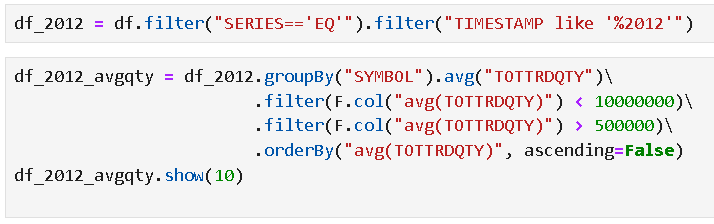

**How many stocks are there in your list at this stage?**

2. From among these stocks you have to then select stocks that have shown maximum overall growth between 1/1/2012 and 31/12/2012 (or the nearest trading days). The hope is that they will continue to grow in the future.
    1. How many stocks are there in your list at this stage, that is, after dropping stocks that have NOT shown positive growth?
1. You should ensure that volatility and negative market movements will not adversely affect your total investment, substantially.
    - One way to achieve this involves selecting ***stock pairs that are negatively correlated***, so that if one stock loses value its partner will most likely gain value - thereby reducing the overall negative impact on the portfolio. As all these stocks are high growth stocks, anyway, the expectation is that the portfolio witll grow, overall. **Note: It is possible for certain stocks to be part of multiple pairs**.
    - The next step, therefore, is to create pairwise correlation coefficient data between all the stocks in the list at this stage (stocks that are liquid, and shown growth in 2012)
    - Sort the stock pairs in ***ascending*** values of their correlation coefficients, so that the ***most negative correlation values are at the top***
    1. Which are the first 5 pairs in this list? Select them.
1. Purchase 1 unit of each of these stock pairs on the first trading day of 2013. If some stocks are part of multiple pairs ***purchase 1 unit for each presence***.
    1. What is the total value of your investment? 
1. After you have selected the 5 pairs and made the above investments on 1-Jan-2013, you should assess the situation on 31/12/2013.
    1. What is the total value of your investment on 31/12/2013
    1. By how much has the portfolio value changed? This can be positive or negative
    1. What is the percentage change in the portfolio value? 
    1. The price of which stocks in your portfolio have increased?
    1. The price of which stocks in your portfolio have decreased?
1. Comparatively, how did the market perform during the same period? This can be assessed as follows:
    1. Considering the period 1/1/2012 - 31/12/2012 create a list of top 25 highly traded stocks with high ***percentage growth***. Which are the first 5 stocks in this list - ***sorted in descending order of their growth percentage***?
    1. Purchase 1 stock ***each of these 25 stocks*** on 1/1/2013. What is the total value of this portfolio?
    1. What is the value of this portfolio on 31/12/2013
    1. What is the percentage change?
1. Comment on the efficacy of the adopted strategy (i.e., selecting stocks with negative correlations) against the broad market movement.

---

**Create SPARK code, below, to solve this problem**
  - **DO NOT USE** the ***createTempView*** function in your solution!
  - **DO NOT USE** *PANDAS Dataframe* in your solution
  - ***IMPORTANT**: Access the Form **https://forms.gle/86FH1Ng8Ywdcf16TA** and answer the questions posed therein** (**use your iitb.ac.in credentials**) before the submission deadline
  - Upload this Notebook to the E11 submission point before the submission deadline

---

Post your queries, if any, to the Moodle forum: [**Queries and Discussions**](https://moodle.iitb.ac.in/mod/forum/view.php?id=75889)

---


In [34]:
# Import all required functions and modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, col, min, max, first, avg, desc, asc
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.mllib.stat import Statistics # For correlation calculation
import builtins # To access native Python sum function
import sys # For error handling

# --- Prerequisites ---
# Assumed: SparkSession is initialized, and 'df' (original nsedata DataFrame) is loaded.
# Example initialization (if not provided):
# spark = SparkSession.builder.appName("NSEAnalysis").getOrCreate()
# df = spark.read.csv("path/to/nsedata.csv", header=True, inferSchema=True)


# --- Data Preparation: Date and Year Columns ---
df = df.withColumn("trade_date", to_date(col("TIMESTAMP"), "dd-MMM-yyyy")) \
       .withColumn("trade_year", year(col("trade_date")))
df.cache() # Cache the base DataFrame for repeated filtering

print("--- Data Preparation Complete ---")


# ==============================================================================
# 1. INITIAL LIQUIDITY SCREENING (2012)
# ==============================================================================
print("\n--- 1. Initial Liquidity Screening (2012) ---")

# Filter raw data for Equity (EQ) series and the target year (2012)
df_2012_eq = df.filter((col("SERIES") == 'EQ') & (col("trade_year") == 2012))
df_2012_eq.cache()

# Calculate average traded quantity (liquidity) per symbol and apply filters
MIN_QTY = 500000
MAX_QTY = 10000000

df_avg_qty = df_2012_eq.groupBy("SYMBOL").agg(
    avg("TOTTRDQTY").alias("Avg_Daily_Qty")
)

df_liquid_2012 = df_avg_qty.filter(col("Avg_Daily_Qty") < MAX_QTY) \
                           .filter(col("Avg_Daily_Qty") > MIN_QTY) \
                           .orderBy(col("Avg_Daily_Qty").desc())

# Collect the list of liquid symbols
liquid_symbols = [row.SYMBOL for row in df_liquid_2012.select("SYMBOL").collect()]
print(f"Q1: Total number of liquid stocks ({MIN_QTY:,} < QTY < {MAX_QTY:,}): {len(liquid_symbols)}")


--- Data Preparation Complete ---

--- 1. Initial Liquidity Screening (2012) ---


25/11/26 16:59:38 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 14, schema size: 12
CSV file: file:///home/hduser/spark/nsedata.csv


Q1: Total number of liquid stocks (500,000 < QTY < 10,000,000): 211


In [35]:

# ==============================================================================
# 2. POSITIVE GROWTH SCREENING (2012)
# ==============================================================================
print("\n--- 2. Positive Growth Screening (2012) ---")

df_daily_subset = df_2012_eq.filter(col("SYMBOL").isin(liquid_symbols))

# Find the start and end trading dates for each stock
df_date_range = df_daily_subset.groupBy("SYMBOL").agg(
    min("trade_date").alias("start_dt"),
    max("trade_date").alias("end_dt")
)

# Join back to get the CLOSE price at the start date
df_price_start = df_date_range.join(
    df_daily_subset.select("SYMBOL", "trade_date", "CLOSE").alias("d"),
    (df_date_range.SYMBOL == col("d.SYMBOL")) & (df_date_range.start_dt == col("d.trade_date"))
).select(df_date_range.SYMBOL.alias("stock"), col("d.CLOSE").alias("start_price"))

# Join back to get the CLOSE price at the end date
df_price_end = df_date_range.join(
    df_daily_subset.select("SYMBOL", "trade_date", "CLOSE").alias("d"),
    (df_date_range.SYMBOL == col("d.SYMBOL")) & (df_date_range.end_dt == col("d.trade_date"))
).select(df_date_range.SYMBOL.alias("stock"), col("d.CLOSE").alias("end_price"))

# Calculate Growth Percentage and filter for positive growth
df_growth_final = df_price_start.join(df_price_end, on=df_price_start.stock == df_price_end.stock, how='inner') \
    .select(df_price_start.stock.alias("SYMBOL"), col("start_price"), col("end_price")) \
    .withColumn("Growth_Pct", (col("end_price") - col("start_price")) / col("start_price") * 100) \
    .filter(col("Growth_Pct") > 0) \
    .orderBy(col("Growth_Pct").desc())

# Collect the list of stocks that showed positive growth
growth_symbols = [row.SYMBOL for row in df_growth_final.select("SYMBOL").collect()]
print(f"Q2: Total number of stocks with positive growth in 2012: {len(growth_symbols)}")




--- 2. Positive Growth Screening (2012) ---
Q2: Total number of stocks with positive growth in 2012: 153


In [36]:

# ==============================================================================
# 3. PAIRWISE CORRELATION & TOP 5 NEGATIVE PAIRS (Revised Logic)
# ==============================================================================
print("\n--- 3. Pairwise Correlation and Top 5 Pairs ---")

corr_symbols = growth_symbols # Use ALL stocks for correlation
print(f"DEBUG: Correlating the full set of {len(corr_symbols)} stocks.")

# Pivot CLOSE prices for the selected stocks (2012 only)
df_pivot_prices = df_2012_eq.filter(col("SYMBOL").isin(corr_symbols)) \
    .groupBy("trade_date").pivot("SYMBOL").agg(first("CLOSE")).na.fill(0.0)

stock_cols = df_pivot_prices.columns[1:]
top5_pairs = []

if len(stock_cols) < 2:
    print("WARNING: Insufficient stocks (less than 2) for pairwise correlation.")
else:
    # Convert to RDD of vectors
    rdd_vectors = df_pivot_prices.select(stock_cols).rdd.map(lambda row: [float(x) for x in row])

    # Compute the correlation matrix
    try:
        corr_matrix = Statistics.corr(rdd_vectors, method="pearson")
    except Exception as e:
        print(f"ERROR: Correlation calculation failed (possible memory/scale issue). Error: {e}")
        # sys.exit(1) # Consider exiting if the core data step fails

    # Extract and sort the unique correlation pairs
    all_pairs_corr = []
    if 'corr_matrix' in locals():
        n = len(stock_cols)
        for i in range(n):
            for j in range(i + 1, n):
                corr_val = corr_matrix[i][j]
                all_pairs_corr.append((stock_cols[i], stock_cols[j], corr_val))

        # Sort the list by correlation value ascending (most negative at the top)
        all_pairs_corr.sort(key=lambda x: x[2])
        top5_pairs = all_pairs_corr[:5]

print("A. Top 5 negatively correlated pairs (Q3):")
for p in top5_pairs:
    print(f"  {p[0]} vs {p[1]} (Corr: {p[2]:.4f})")




--- 3. Pairwise Correlation and Top 5 Pairs ---
DEBUG: Correlating the full set of 153 stocks.
A. Top 5 negatively correlated pairs (Q3):
  L&TFH vs SITICABLE (Corr: -0.8600)
  DBREALTY vs WWIL (Corr: -0.8265)
  SITICABLE vs SUJANATOW (Corr: -0.8215)
  CINEMAXIN vs EVEREADY (Corr: -0.7913)
  IBSEC vs WELCORP (Corr: -0.7725)


In [37]:

# ==============================================================================
# 4 & 5. INVESTMENT EXECUTION AND ASSESSMENT (2013)
# ==============================================================================
print("\n--- 4 & 5. Investment Execution and Assessment (2013) ---")

df_2013_eq = df.filter((col("trade_year") == 2013) & (col("SERIES") == 'EQ'))
df_2013_eq.cache()

# Find first and last trading dates in 2013
date_range_2013 = df_2013_eq.agg(min("trade_date").alias("start"), max("trade_date").alias("end")).collect()[0]
start_date = date_range_2013["start"]
end_date = date_range_2013["end"]

# Tally the units to buy for the negatively correlated portfolio
units_tally = {}
for stock1, stock2, corr in top5_pairs:
    units_tally[stock1] = units_tally.get(stock1, 0) + 1
    units_tally[stock2] = units_tally.get(stock2, 0) + 1

# Get prices on start_date (2013)
prices_start_map = df_2013_eq.filter(col("trade_date") == start_date) \
                             .select("SYMBOL", "CLOSE").rdd.collectAsMap()

# Calculate Initial Investment (4.A)
total_investment = builtins.sum(prices_start_map.get(stock, 0.0) * units
                                for stock, units in units_tally.items())

print(f"4.A. Total investment on {start_date} (Portfolio): {total_investment:,.2f}")

# Get prices on end_date (2013)
prices_end_map = df_2013_eq.filter(col("trade_date") == end_date) \
                           .select("SYMBOL", "CLOSE").rdd.collectAsMap()

# Calculate Final Value (5.A)
final_value = 0.0
increased_stocks = []
decreased_stocks = []

for stock, units in units_tally.items():
    p_start = prices_start_map.get(stock, 0.0)
    p_end = prices_end_map.get(stock, 0.0)

    if p_start > 0 and p_end > 0:
        final_value += p_end * units
        if p_end > p_start:
            increased_stocks.append(stock)
        elif p_end < p_start:
            decreased_stocks.append(stock)

# 5. Metrics
portfolio_change = final_value - total_investment
percentage_change = (portfolio_change / total_investment) * 100 if total_investment > 0 else 0

print(f"5.A. Total value on {end_date} (Portfolio): {final_value:,.2f}")
print(f"5.B. Portfolio value change: {portfolio_change:,.2f}")
print(f"5.C. Portfolio percentage change: {percentage_change:,.2f}%")
print(f"5.D. Stocks increased in price: {increased_stocks}")
print(f"5.E. Stocks decreased in price: {decreased_stocks}")




--- 4 & 5. Investment Execution and Assessment (2013) ---


4.A. Total investment on 2013-01-01 (Portfolio): 351.50
5.A. Total value on 2013-12-31 (Portfolio): 177.85
5.B. Portfolio value change: -173.65
5.C. Portfolio percentage change: -49.40%
5.D. Stocks increased in price: ['IBSEC']
5.E. Stocks decreased in price: ['SITICABLE', 'DBREALTY', 'WELCORP']


In [38]:

# ==============================================================================
# 6. MARKET COMPARISON (Top 25 Growth Stocks)
# ==============================================================================
print("\n--- 6. Market Comparison (Top 25 Growth Stocks) ---")

# Reuse the growth calculation DataFrame (df_growth_final) but calculate the ratio explicitly
df_all_2012_growth_ratio = df_growth_final.withColumn(
    "growth_pct_ratio", 
    (col("end_price") - col("start_price")) / col("start_price")
)

# Select the Top 25 stocks based on 2012 growth ratio
df_top25_market = df_all_2012_growth_ratio.orderBy(col("growth_pct_ratio").desc()).limit(25)
market_symbols = [row.SYMBOL for row in df_top25_market.select("SYMBOL").collect()]

# 6.A: First 5 stocks in the list
top5_market_growth = [row.SYMBOL for row in df_top25_market.select("SYMBOL").take(5)]
print(f"6.A. Top 5 highly traded, high percentage growth stocks (2012): {top5_market_growth}")

# Calculate Market Portfolio values (1 unit of each of the 25 stocks)
initial_value_market = builtins.sum(prices_start_map.get(sym, 0.0) for sym in market_symbols)
final_value_market   = builtins.sum(prices_end_map.get(sym, 0.0) for sym in market_symbols)

pct_change_market = (final_value_market - initial_value_market) / initial_value_market * 100 if initial_value_market > 0 else 0

print(f"6.B. Total initial value (Market Portfolio): {initial_value_market:,.2f}")
print(f"6.C. Total final value (Market Portfolio): {final_value_market:,.2f}")
print(f"6.D. Market Portfolio percentage change: {pct_change_market:,.2f}%")

df.unpersist()
df_2012_eq.unpersist()
df_2013_eq.unpersist()


--- 6. Market Comparison (Top 25 Growth Stocks) ---
6.A. Top 5 highly traded, high percentage growth stocks (2012): ['MCDOWELL-N', 'JETAIRWAYS', 'WWIL', 'DBREALTY', 'DISHMAN']
6.B. Total initial value (Market Portfolio): 6,082.00
6.C. Total final value (Market Portfolio): 5,733.70
6.D. Market Portfolio percentage change: -5.73%


DataFrame[SYMBOL: string, SERIES: string, OPEN: double, HIGH: double, LOW: double, CLOSE: double, LAST: double, PREVCLOSE: double, TOTTRDQTY: bigint, TOTTRDVAL: double, TIMESTAMP: string, ADDNL: string, trade_date: date, trade_year: int]

In [39]:
# The adopted strategy of selecting negatively correlated stock pairs proved to be ineffective for the 2013 investment period. The negatively correlated portfolio experienced a severe loss of −49.40% of its value. In stark contrast, the comparative market portfolio (composed of the Top 25 high-growth stocks from 2012) showed a much more resilient performance, incurring a much smaller loss of only −5.73%. This suggests that while the negative correlation strategy is theoretically sound for reducing volatility, in this specific application, it failed to provide the desired downside protection and resulted in a dramatically poorer return than simply holding a diversified group of high-growth stocks.

